In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

# 데이터 준비

In [2]:
# fashion mnist 데이터셋 로드
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [3]:
# 이미지 입력시에는 채널에 대한 정보가 있어야함
# 지금은 Conv2D를 적용하기 위해서 채널 차원을 추가
scaled_train = x_train.reshape(-1, 28, 28, 1) / 255

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
scaled_train.shape

(60000, 28, 28, 1)

In [6]:
x_train[0, 0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8)

In [7]:
scaled_train[0, 0]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

# 합성곱 신경망 모델 구성

1. 합성곱 층으로 이미지에서 특징을 감지
2. 밀집층으로 클래스에 따른 분류 확률을 계산

In [8]:
model = keras.Sequential()

In [9]:
# 합성곱층 추가
model.add(keras.layers.Conv2D(32, kernel_size = 3, activation = "relu", padding = "same",
                              input_shape = (28, 28, 1)))

- 패션MNIST 이미지가 (28, 28)크기에 세임 패딩을 적용, 32개의 필터 사용
    - 출력되는 특성맵의 크기는 (28, 28, 32)

In [10]:
# 풀링층 추가
model.add(keras.layers.MaxPool2D(2))

- (2, 2)크기의 커널을 이용하여 풀링을 적용해서 특성맵의 크기가 절반으로 줄어들고 특성맵의 깊이는 그대로
    - 출력되는 특성맵의 크기는 (14, 14, 32)

In [11]:
# 두 번째 합성곱 - 풀링층 추가
model.add(keras.layers.Conv2D(64, kernel_size = 3, activation = "relu", padding = "same"))
model.add(keras.layers.MaxPool2D(2))

- (14, 14) 크기에 세임 패딩, 64개 필터 사용
    - 출력되는 특성맵의 크기 (14, 14, 64)
    
- (2, 2)크기의 커널을 이용하여 풀링
    - 출력되는 특성맵의 크기 (7, 7, 64)

In [12]:
# 3차원 특성맵을 일렬로 펼침
# 10개의 뉴런을 가진 밀집층에서 확률을 계산하기 때문에
model.add(keras.layers.Flatten())

In [13]:
# 밀집 은닉층을 하나 더 추가한 후 드롭아웃을 넣어 과대적합을 방지하고 성능을 개선
model.add(keras.layers.Dense(100, activation = "relu"))
model.add(keras.layers.Dropout(0.4))

In [14]:
# 출력층
# 10개의 클래스를 분류하는 다중 분류
model.add(keras.layers.Dense(10, activation = "softmax"))

In [15]:
# 모델 구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

- 파라미터 개수
    - 첫 번째 합성곱 층
        - 필터의 크기 : (3, 3, 1)
        - 필터의 개수 : 32
        - 3 * 3 * 1 * 32 + 32 = 320
        
    - 두 번째 합성곱 층
        - 필터의 크기 : (3, 3, 32)
        - 필터의 개수 : 64
        - 3 * 3 * 32 * 64 + 64 = 18496
        
    - 밀집 은닉 층
        - Flatten층에서 (3136,)크기의 배열이 전달 (7 * 7 * 64)
        - 3136 * 100 + 100 = 313700
        
    - 출력층
        - 밀집 은닉층에서 (100,) 크기의 배열이 전달
        - 100 * 10 + 10 = 1010

# 모델 훈련

- 옵티마이저 : Adam
- 콜백함수 : ModelCheckpoint, EarlyStopping

In [21]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-cnn-model.h5",
                                                save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True)

In [22]:
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = "accuracy")

In [23]:
history = model.fit(scaled_train, y_train, epochs = 20, validation_split = 0.2,
                    callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 19s 10ms/step - loss: 0.5122 - accuracy: 0.8195 - val_loss: 0.3302 - val_accuracy: 0.8798
Epoch 2/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.3351 - accuracy: 0.8799 - val_loss: 0.2730 - val_accuracy: 0.8998
Epoch 3/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2872 - accuracy: 0.8964 - val_loss: 0.2617 - val_accuracy: 0.9026
Epoch 4/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2538 - accuracy: 0.9082 - val_loss: 0.2572 - val_accuracy: 0.9049
Epoch 5/20
1500/1500 [==============================] - 17s 11ms/step - loss: 0.2316 - accuracy: 0.9149 - val_loss: 0.2297 - val_accuracy: 0.9170
Epoch 6/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.2108 - accuracy: 0.9221 - val_loss: 0.2452 - val_accuracy: 0.9127
Epoch 7/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.1948 - accuracy: 0.9279 - val_loss: 0.2256 -

# 훈련 로그 확인

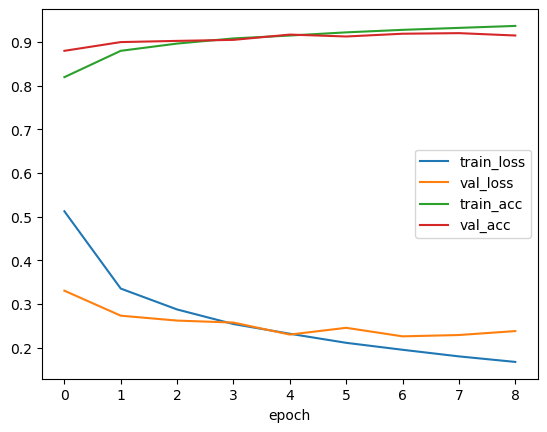

In [24]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.xlabel("epoch")
plt.legend()

plt.show()

# 모델 성능 검증

In [25]:
scaled_test = x_test.reshape(-1, 28, 28, 1) / 255

In [26]:
model.evaluate(scaled_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.2444 - accuracy: 0.9162


[0.24443742632865906, 0.9161999821662903]

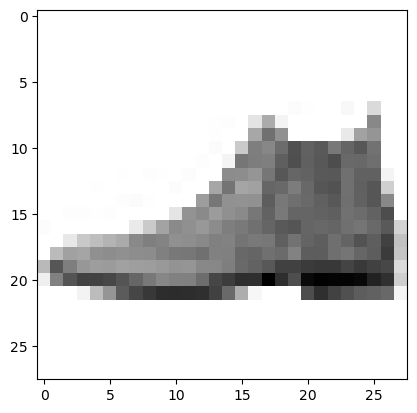

In [30]:
# 데이터 시각화
plt.imshow(scaled_test[0].reshape(28, 28), cmap = "gray_r")
plt.show()

In [33]:
# predict 메서드는 입력 데이터가 배치차원이 있을 것으로 가정하기 때문에
# 배치차원이 1인 형태로 변형하여 전달
preds = model.predict(scaled_test[[0]])
print(preds)

1/1 [==============================] - 0s 30ms/step
[[7.4509067e-08 4.8068682e-09 2.0847997e-09 1.4240438e-09 3.2578416e-09
  1.0652707e-05 9.1887822e-09 6.0750954e-05 2.2999478e-08 9.9992847e-01]]


In [34]:
scaled_test[0].shape

(28, 28, 1)

In [35]:
scaled_test[[0]].shape

(1, 28, 28, 1)

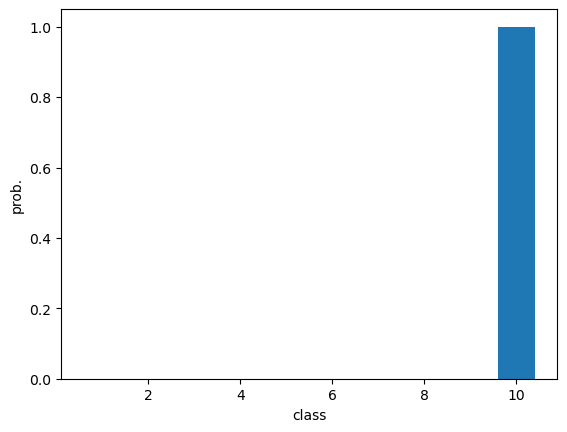

In [36]:
plt.figure()

plt.bar(range(1, 11), preds[0])

plt.xlabel("class")
plt.ylabel("prob.")

plt.show()

In [37]:
# 레이블 리스트
classes = ["티셔츠", "바지", "스웨터", "드레스", "코트", "샌달", "셔츠", "스니커즈", "가방",
           "앵클 부츠"]

In [38]:
print(classes[np.argmax(preds)])

앵클 부츠


In [39]:
print(classes[y_test[0]])

앵클 부츠
